In [1]:
from bs4 import BeautifulSoup
import requests
import datetime
import pandas as pd
import csv
import numpy as np
import sklearn
import sklearn.preprocessing

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.keras.backend.set_floatx('float64')

# Setup

In [2]:
filename = 'pso2_items.csv'
items = pd.read_csv(filename)
items = items.drop(['index'], axis=1) #oops there's a field called index that is useless in the dataset

# Analysis of data

In [3]:
items.head()

,name,ship,lowest_price,average_price,date
0,Raison Hubris [Ou],1,840000,1453410,1900-08-04 14:00:07
1,Raison Hubris [Ou],1,945000,2037420,1900-08-03 10:00:30
2,Raison Hubris [Ou],1,630000,840000,1900-08-01 17:00:27
3,Raison Hubris [Ou],1,630000,798000,1900-08-01 04:00:59
4,Raison Hubris [Ou],1,630000,735000,1900-07-31 16:00:57


In [4]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94462 entries, 0 to 94461
Data columns (total 5 columns):
name             94462 non-null object
ship             94462 non-null int64
lowest_price     94462 non-null int64
average_price    94462 non-null int64
date             94462 non-null object
dtypes: int64(3), object(2)
memory usage: 3.6+ MB


In [5]:
items.describe()

,ship,lowest_price,average_price
count,94462.000000,9.446200e+04,9.446200e+04
mean,1.998465,1.088296e+07,2.300362e+07
std,0.602595,7.745427e+07,1.834816e+08
min,1.000000,1.050000e+03,3.948000e+03
25%,2.000000,5.985000e+05,7.035000e+05
50%,2.000000,2.396099e+06,2.949772e+06
75%,2.000000,8.485574e+06,1.011500e+07
max,3.000000,1.050000e+10,1.050000e+10


In [6]:
# looks like ship 2 has the most items, let's check how many points are contained in ship 2
items['ship'].value_counts()

2    60161
1    17223
3    17078
Name: ship, dtype: int64

In [7]:
# let's just work with ship 2 items to simplify
items_2s = items[items['ship'] == 2]
items_2s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60161 entries, 17223 to 77383
Data columns (total 5 columns):
name             60161 non-null object
ship             60161 non-null int64
lowest_price     60161 non-null int64
average_price    60161 non-null int64
date             60161 non-null object
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002F0E9FE7588>,
      dtype=object)

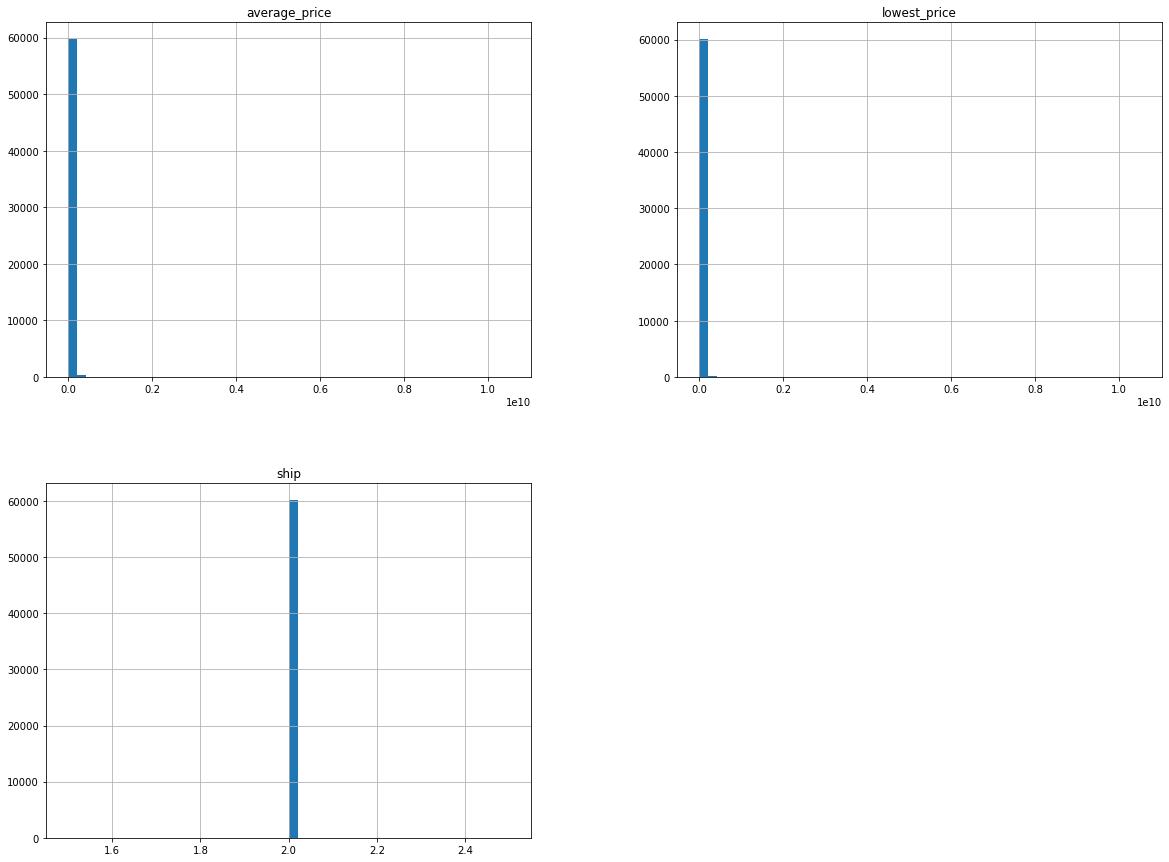

In [8]:
items_2s.hist(bins=50, figsize=(20, 15))

In [9]:
# looks like there are a lot of outliers in the data (there are so many data points on the left)
# check some of the lowest prices
items_2s['lowest_price']

17223    1627500
17224    1627500
17225    1575000
17226    1092000
17227    1789499
          ...   
77379    4999885
77380    4992882
77381    5097893
77382    4988548
77383    5000000
Name: lowest_price, Length: 60161, dtype: int64

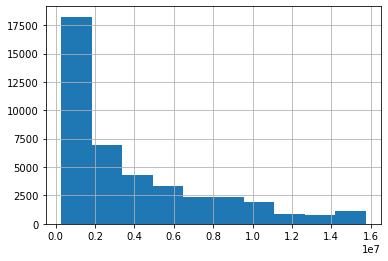

In [10]:
# maybe remove outliers by quantile
lp = items_2s['lowest_price']
lp = lp[lp.between(lp.quantile(.15), lp.quantile(.85))]
lp.hist()

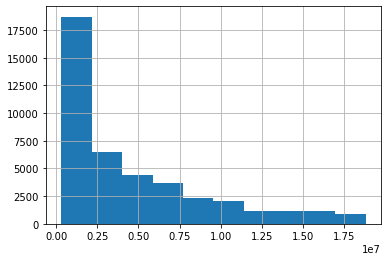

In [11]:
# and for averatge price
lp = items_2s['average_price']
lp = lp[lp.between(lp.quantile(.15), lp.quantile(.85))]
lp.hist()

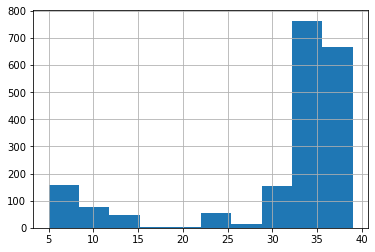

In [12]:
# from the looks of it, the lowest and average price look the same, so i'll just take lowest price as what we will work with
# also, now we know that the items aren't evenly distributed in price, just to keep in mind for later

# let's see what has items the most data points (maybe most popular?)
items_2s['name'].value_counts()
items_2s['name'].value_counts().hist()

In [13]:
# seems like items with suffixes such as [Ou] and [Ba] have more datapoints
items_ou_ba = items_2s[items_2s['name'].str.endswith('[Ou]') | items_2s['name'].str.endswith('[Ba]')]
items_ou_ba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17136 entries, 17223 to 77229
Data columns (total 5 columns):
name             17136 non-null object
ship             17136 non-null int64
lowest_price     17136 non-null int64
average_price    17136 non-null int64
date             17136 non-null object
dtypes: int64(3), object(2)
memory usage: 803.2+ KB


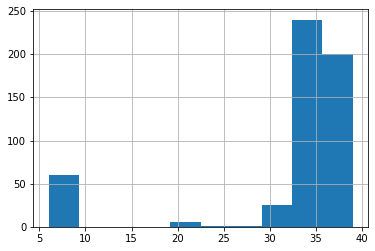

In [14]:
# maybe not..., quite similar to the above graph
items_ou_ba['name'].value_counts()
items_ou_ba['name'].value_counts().hist()

# Preprocessing
### Transform data for machine learning

In [15]:
# we want to grab x number of data points and predict the next y number of data points
# for example, 8 days of prices and predict the next day of prices

# here we want an item to have at least 20 data points
num_items_threshold = 20
items_filtered = items_2s.groupby('name').filter(lambda x: len(x) >= num_items_threshold)

In [16]:
# helper function to split data into a sliding window

# example
# [1..20] data points and we want to split into sliding window of 10 items
# [1..10], [2..11], [3..12], etc...

# this also scales the data with the scaler parameter

def ConvertItemsToTimeSeries(items_2s, input_size, output_size, scaler):
    input_series = []
    output_series = []
    for name, group in items_2s.groupby('name'):
        values = []
        for _, d in group.groupby(['ship', 'date'], sort=True):
            price = d['lowest_price'].to_numpy()
            if price.shape[0] != 1:
                break
            values.append(price)

        if len(values) == 0:
            continue

        values = np.array(values)
        values = scaler.fit_transform(values)

        for i in range(len(values) - input_size - output_size):
            inputs = values[i:i+input_size]
            outputs = values[i+input_size:i+input_size+output_size]
            input_series.append(inputs)
            output_series.append(outputs)

    input_series = np.array(input_series)
    output_series = np.array(output_series)
    input_series = input_series.reshape(-1, 1, input_size)
    output_series = output_series.reshape(-1, 1, output_size)
    
    return input_series, output_series

In [17]:
# try with 10 inputs and predict next one output
input_size = 10
output_size = 1
scaler = sklearn.preprocessing.StandardScaler()

assert(num_items_threshold >= input_size + output_size)
input_series, output_series = ConvertItemsToTimeSeries(items_filtered, input_size, output_size, scaler)
print(input_series.shape, output_series.shape)

(39360, 1, 10) (39360, 1, 1)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

RANDOM_SEED=20 # make sure rerunning this will produce same results since shuffle can be deterministic

# helper function to split into train, validation and test set
# default is 70% test, 10% validation, 20% test
def SplitIntoTrainValTest(input_series, output_series, val=0.7, test=0.8, has_set_seed=True):
    if has_set_seed:
        input_series, output_series = shuffle(input_series, output_series, random_state=RANDOM_SEED)
    else:
        input_series, output_series = shuffle(input_series, output_series)

    train_input_set, valid_input_set, test_input_set = np.split(input_series, [int(val*len(input_series)), int(test*len(input_series))])
    train_output_set, valid_output_set, test_output_set = np.split(output_series, [int(val*len(output_series)), int(test*len(output_series))])
    
    return train_input_set, valid_input_set, test_input_set, train_output_set, valid_output_set, test_output_set

In [19]:
train_input_set, valid_input_set, test_input_set, train_output_set, valid_output_set, test_output_set = SplitIntoTrainValTest(input_series, output_series)
print('Train')
print(train_input_set.shape)
print(train_output_set.shape)
print('Valid')
print(valid_input_set.shape)
print(valid_output_set.shape)
print('Test')
print(test_input_set.shape)
print(test_output_set.shape)

Train
(27552, 1, 10)
(27552, 1, 1)
Valid
(3936, 1, 10)
(3936, 1, 1)
Test
(7872, 1, 10)
(7872, 1, 1)


In [20]:
# convert into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_set, train_output_set))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input_set, valid_output_set))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_set, test_output_set))

# First attempt at machine learning

### some material referenced from https://www.tensorflow.org/tutorials/structured_data/time_series 

#### Note: running this yourself may produce different results, rerun the above code in SplitIntoTrainValTest and set do_shuffle=False

In [21]:
# helper function to fit model
MAX_EPOCHS = 50
BATCH_SIZE = 16

def compile_and_fit(model, train, valid, test, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    model.build(list(train.take(1))[0][0].shape)
    print(model.summary())

    history = model.fit(train, 
                        validation_data=valid,
                        epochs=MAX_EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping])

    test_loss, test_mae = model.evaluate(test)
    
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Mean Absolute Error')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print('Test loss', test_loss)
    print('Test mae', test_mae)
    
    return history, test_loss, test_mae

In [22]:
# take some examples and plot
def plot_example(dataset, model, num_instances=1):
    data = dataset.take(num_instances)
    for x, y in data:
        x, y = x[:num_instances], y[:num_instances]
        y_pred = model.predict(x)
        x, y = tf.reshape(x[0], (-1,)) , y[0]
        
        input_size = x.shape[0]
        output_size = y.shape[0]
        
        input_indices = range(input_size)
        output_indices = range(input_size, input_size + output_size)
        plt.plot(input_indices, x, label='Inputs', marker='.', zorder=-10)
        plt.scatter(output_indices, y, edgecolors='k', label='Labels', c='#2ca02c', s=64)
        plt.scatter(output_indices, y_pred, marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        plt.show()

## Models

### Single step

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 1)                    11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27550/27552 [===

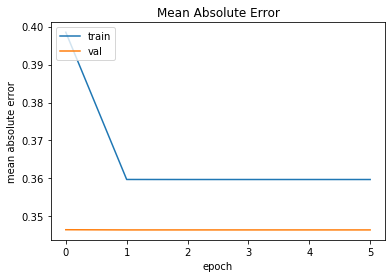

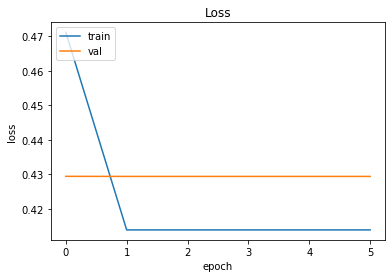

Test loss 0.42553430316115787
Test mae 0.3512452446318121
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


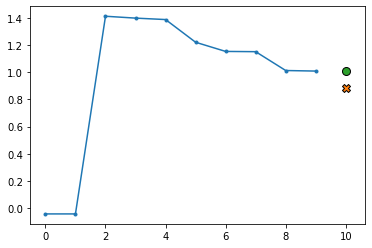

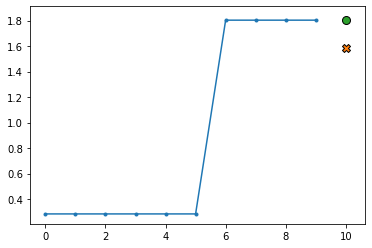

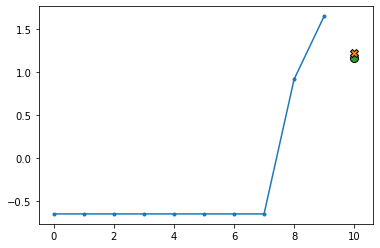

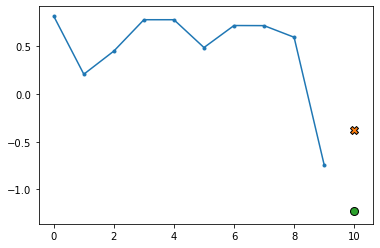

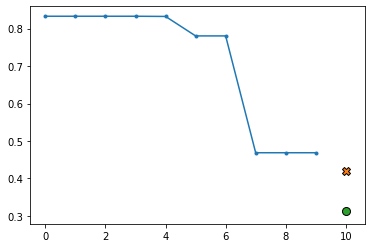

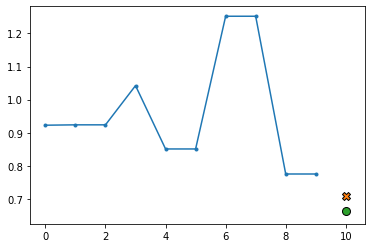

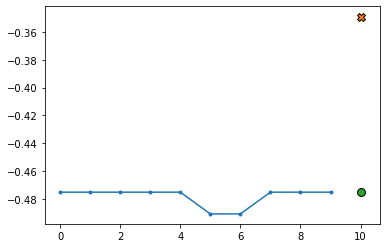

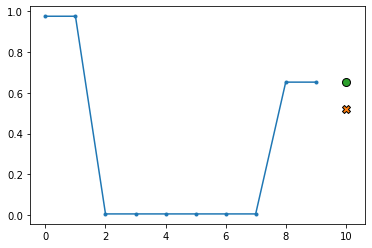

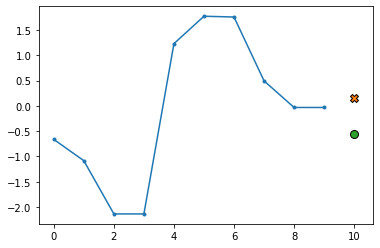

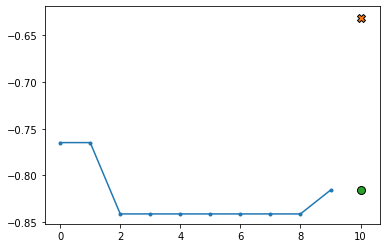

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/simple_linear_model_10_1\assets


In [23]:
simple_linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=output_size)
])

_, simple_linear_model_loss, simple_linear_model_mae = compile_and_fit(simple_linear_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, simple_linear_model, 10)
simple_linear_model.save(f'models/simple_linear_model_{input_size}_{output_size}')

In [24]:
# compare with minmaxscaler to scale data?
input_size = 10
output_size = 1
#scaler = sklearn.preprocessing.StandardScaler() 
scaler = sklearn.preprocessing.MinMaxScaler()

assert(num_items_threshold >= input_size + output_size)
input_series, output_series = ConvertItemsToTimeSeries(items_filtered, input_size, output_size, scaler)
train_input_set, valid_input_set, test_input_set, train_output_set, valid_output_set, test_output_set = SplitIntoTrainValTest(input_series, output_series)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (1, 1)                    11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27528/27552 [=

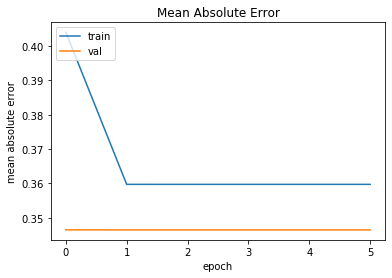

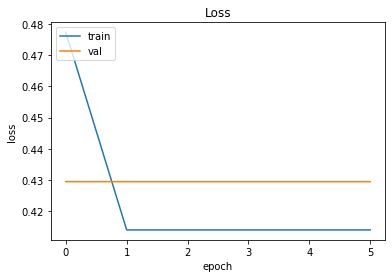

Test loss 0.42553430316115787
Test mae 0.3512452446318121
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


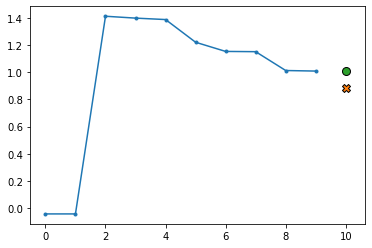

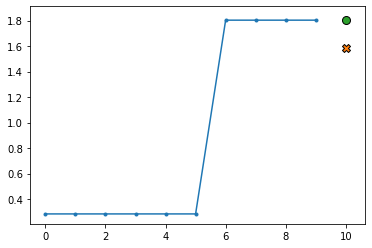

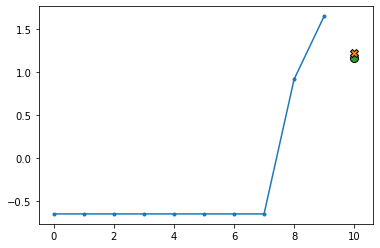

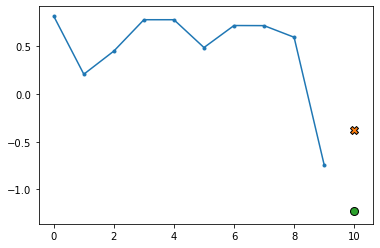

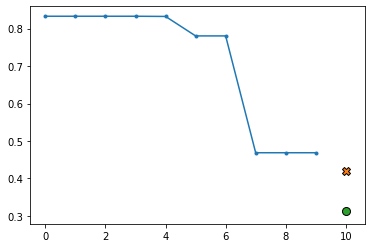

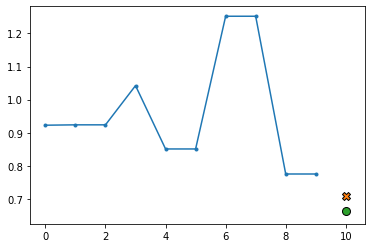

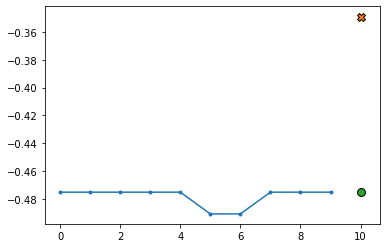

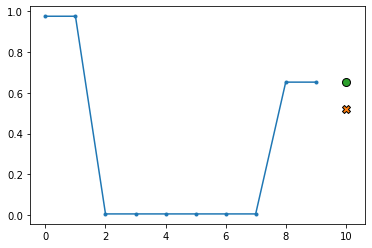

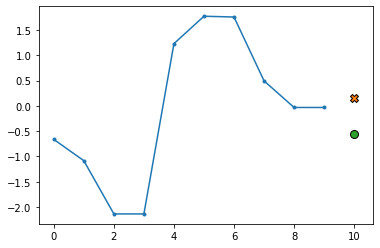

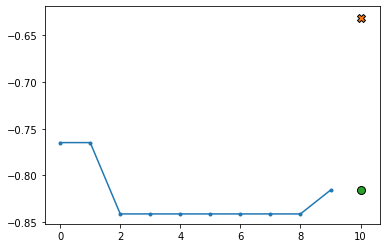

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/simple_linear_model_10_1\assets


In [25]:
simple_linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=output_size)
])

_, simple_linear_model_loss, simple_linear_model_mae = compile_and_fit(simple_linear_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, simple_linear_model, 10)
simple_linear_model.save(f'models/simple_linear_model_{input_size}_{output_size}')

In [26]:
# loss/error less, so we will stick to minmaxscaler as the "better" scaling method in this case
# not definite since i trained only a single basic model with the scaled data without cross validation :) 
# and the data is maybe randomized in a lucky way

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (1, 64)                   704       
_________________________________________________________________
dense_3 (Dense)              (1, 64)                   4160      
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

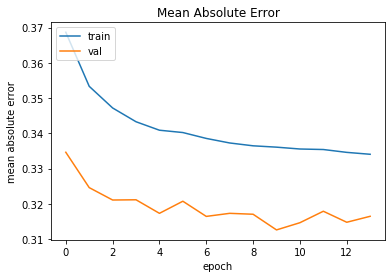

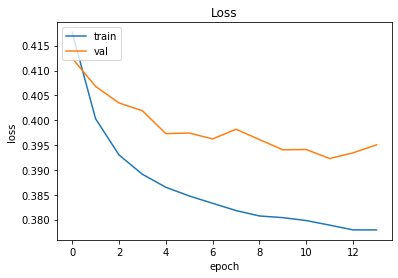

Test loss 0.3928878368082412
Test mae 0.3203916135211748
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


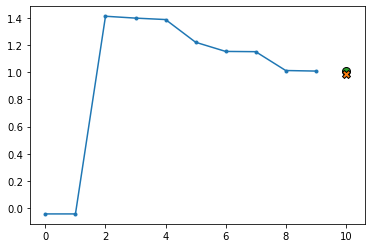

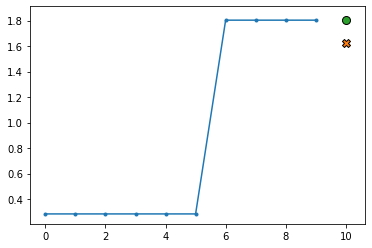

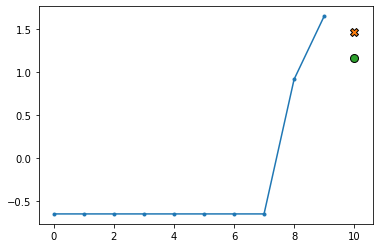

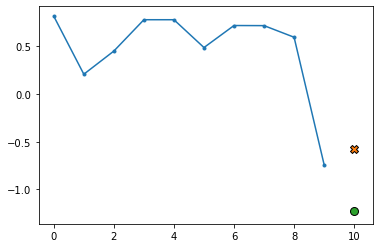

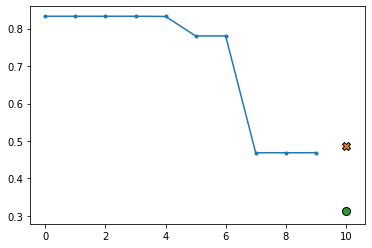

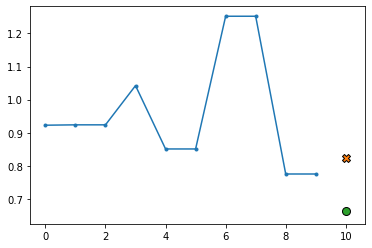

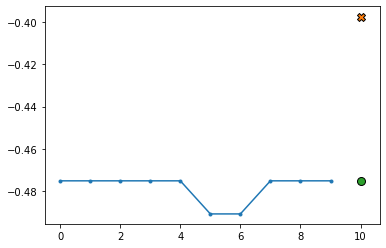

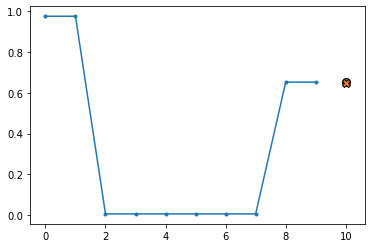

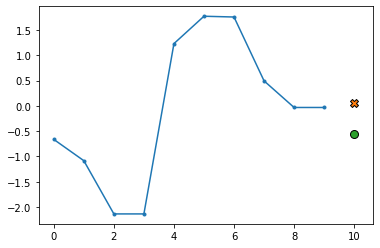

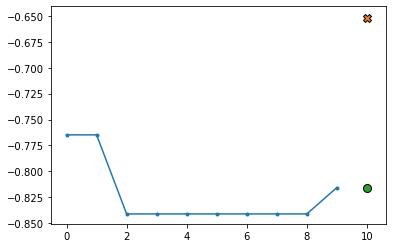

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/complex_linear_model_10_1\assets


In [27]:
complex_linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=output_size)
])

_, complex_linear_model_loss, complex_linear_model_mae = compile_and_fit(complex_linear_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, complex_linear_model, 10)
complex_linear_model.save(f'models/complex_linear_model_{input_size}_{output_size}')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (1, 1, 10)                0         
_________________________________________________________________
conv1d (Conv1D)              (1, 1, 32)                352       
_________________________________________________________________
dense_5 (Dense)              (1, 1, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (1, 1, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this w

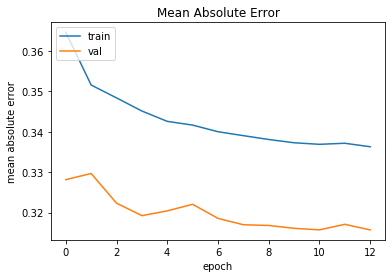

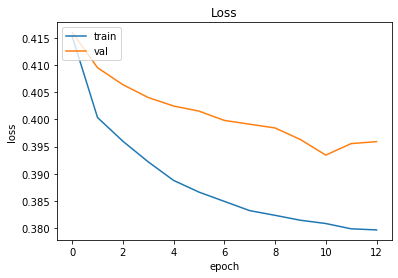

Test loss 0.39569639184569777
Test mae 0.3218377076283818
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


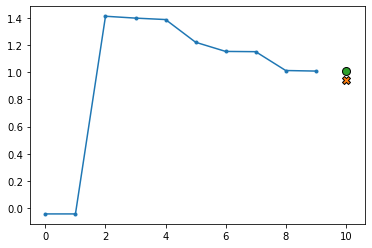

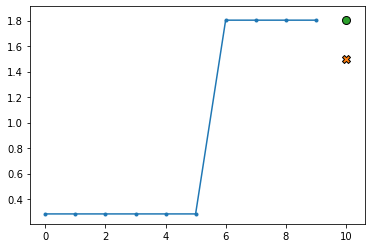

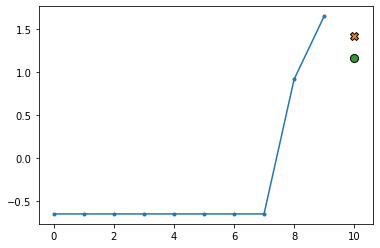

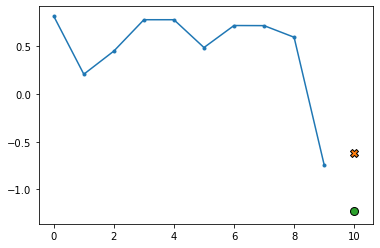

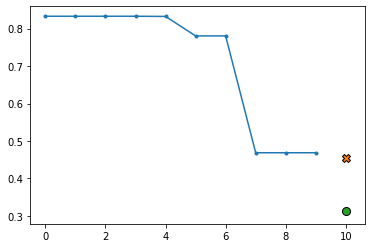

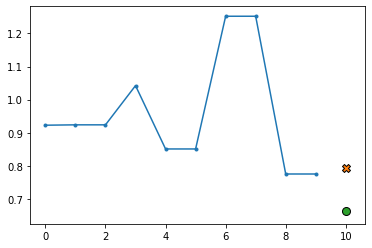

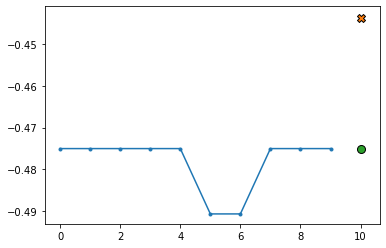

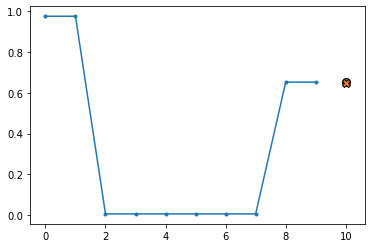

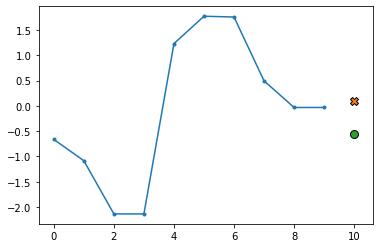

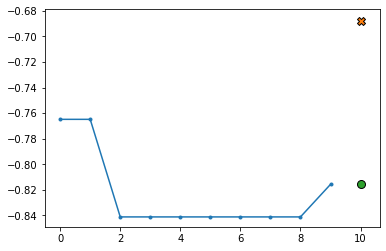

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/conv_model_10_1\assets


In [28]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Reshape([1, -1]),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(1,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=output_size)
])

_, conv_model_loss, conv_model_mae = compile_and_fit(conv_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, conv_model, 10)
conv_model.save(f'models/conv_model_{input_size}_{output_size}')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru (GRU)                    (1, 32)                   4224      
_________________________________________________________________
dense_7 (Dense)              (1, 1)                    33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

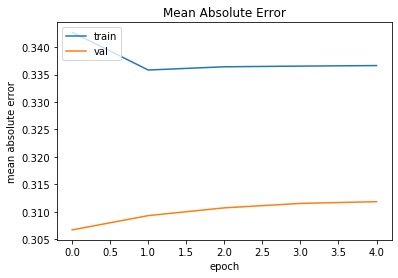

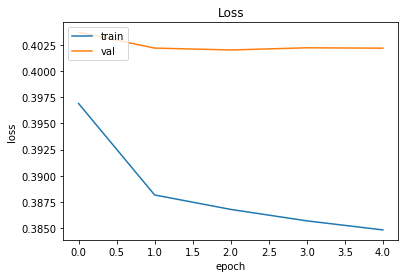

Test loss 0.40065090379529716
Test mae 0.3171274560544834
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


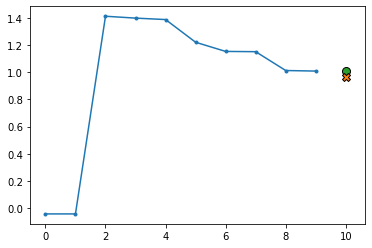

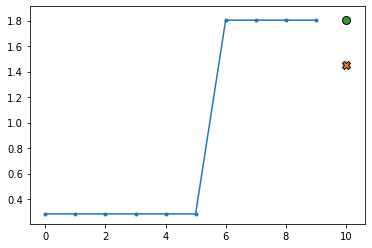

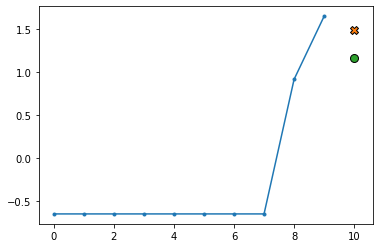

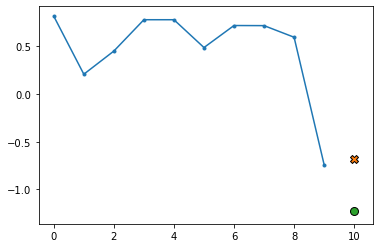

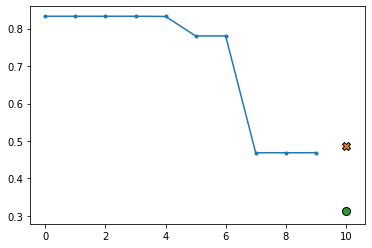

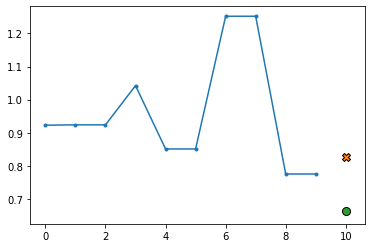

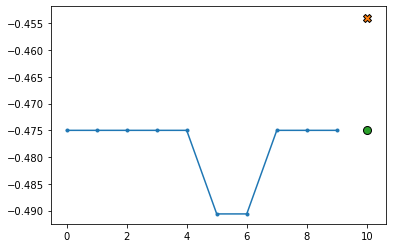

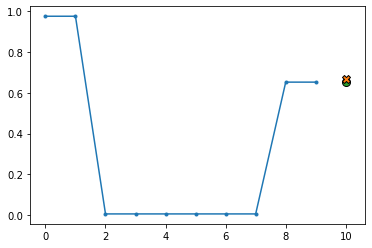

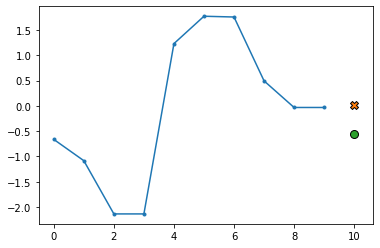

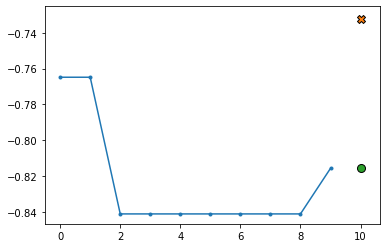

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/gru_model_10_1\assets


In [29]:
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1, -1]),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(units=output_size)
])

_, gru_model_loss, gru_model_mae = compile_and_fit(gru_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, gru_model, 10)
gru_model.save(f'models/gru_model_{input_size}_{output_size}')

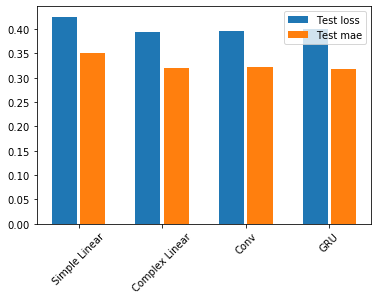

In [30]:
width = 0.3
test_loss = [simple_linear_model_loss, complex_linear_model_loss, conv_model_loss, gru_model_loss]
test_mae = [simple_linear_model_mae, complex_linear_model_mae, conv_model_mae, gru_model_mae]
x = np.arange(len(test_loss))
plt.bar(x - 0.17, test_loss, width, label='Test loss')
plt.bar(x + 0.17, test_mae, width, label='Test mae')
plt.xticks(ticks=x, labels=['Simple Linear', 'Complex Linear', 'Conv', 'GRU'], rotation=45)
plt.legend()

### Multi step

In [31]:
input_size = 10
output_size = 10
scaler = sklearn.preprocessing.MinMaxScaler()

assert(num_items_threshold >= input_size + output_size)
input_series, output_series = ConvertItemsToTimeSeries(items_filtered, input_size, output_size, scaler)
train_input_set, valid_input_set, test_input_set, train_output_set, valid_output_set, test_output_set = SplitIntoTrainValTest(input_series, output_series)

train_dataset = tf.data.Dataset.from_tensor_slices((train_input_set, train_output_set))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input_set, valid_output_set))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_set, test_output_set))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (1, 10)                   110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17006/17125 

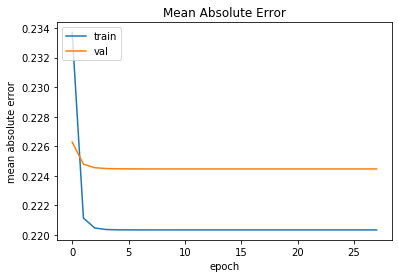

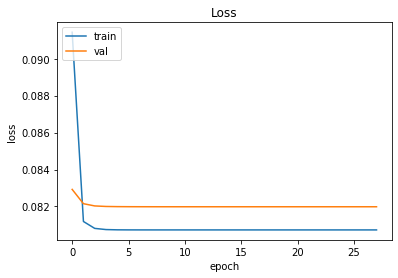

Test loss 0.08321927268798808
Test mae 0.22623166547821427
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


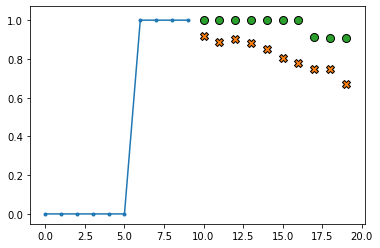

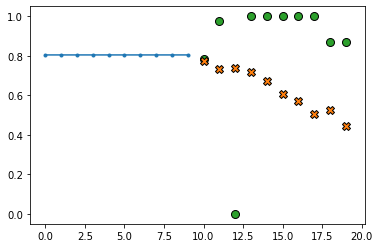

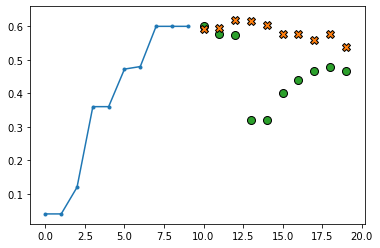

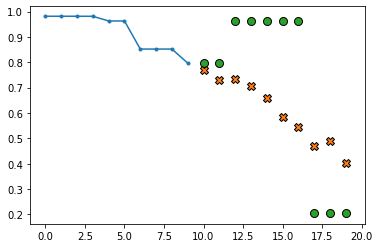

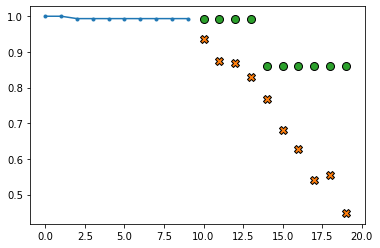

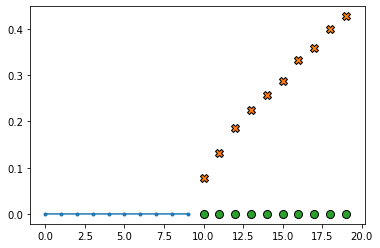

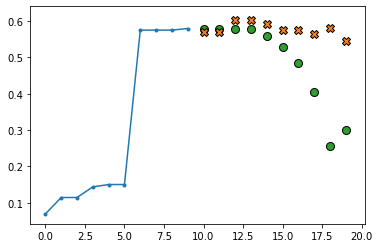

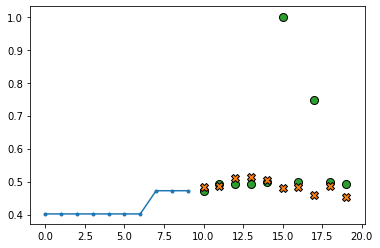

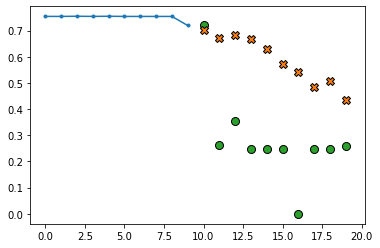

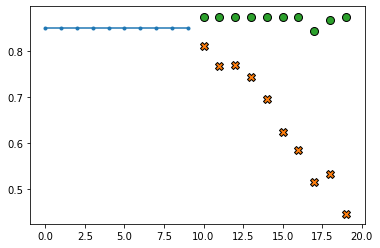

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/simple_linear_model_10_10\assets


In [32]:
simple_linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=output_size)
])

_, simple_linear_model_loss, simple_linear_model_mae = compile_and_fit(simple_linear_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, simple_linear_model, 10)
simple_linear_model.save(f'models/simple_linear_model_{input_size}_{output_size}')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (1, 64)                   704       
_________________________________________________________________
dense_10 (Dense)             (1, 64)                   4160      
_________________________________________________________________
dense_11 (Dense)             (1, 10)                   650       
Total params: 5,514
Trainable params: 5,514
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

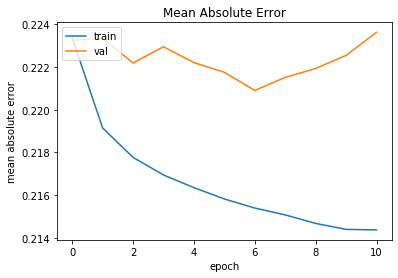

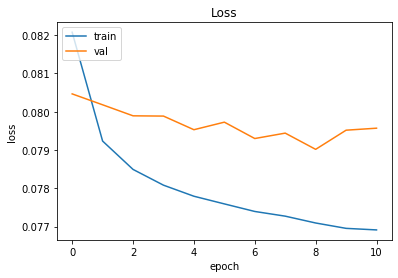

Test loss 0.07825918895859792
Test mae 0.22225402848142464
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


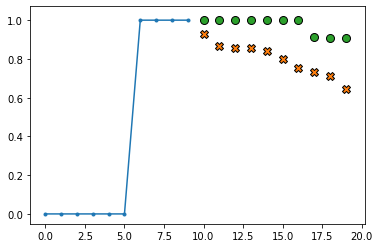

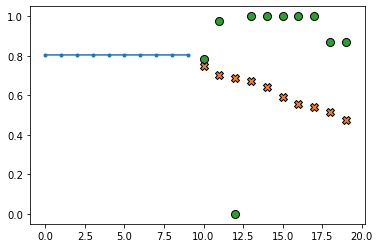

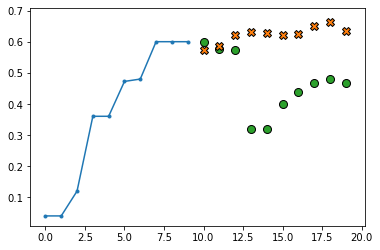

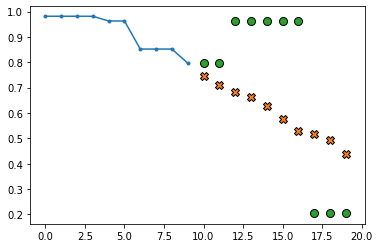

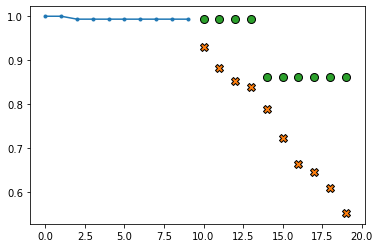

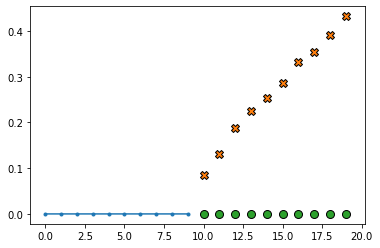

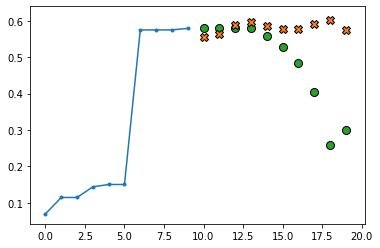

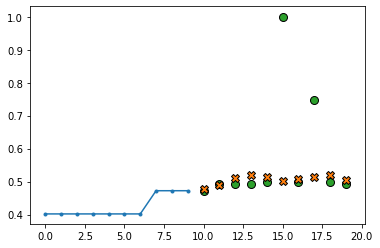

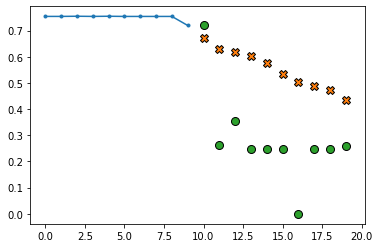

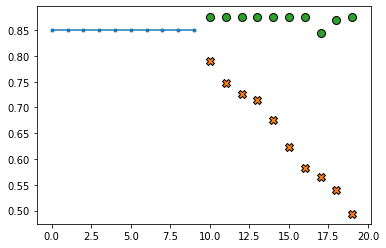

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/complex_linear_model_10_10\assets


In [33]:
complex_linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=output_size)
])

_, complex_linear_model_loss, complex_linear_model_mae = compile_and_fit(complex_linear_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, complex_linear_model, 10)
complex_linear_model.save(f'models/complex_linear_model_{input_size}_{output_size}')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
conv1d_1 (Conv1D)            (1, 1, 32)                352       
_________________________________________________________________
dense_12 (Dense)             (1, 1, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (1, 1, 10)                330       
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this w

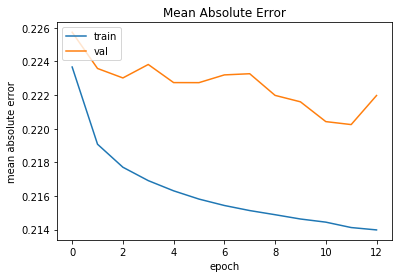

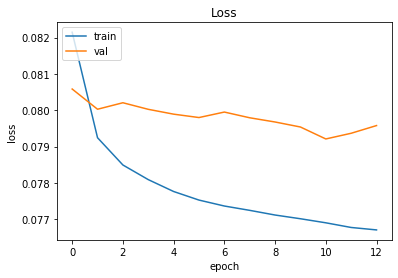

Test loss 0.07883729971368325
Test mae 0.2214490184250964
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


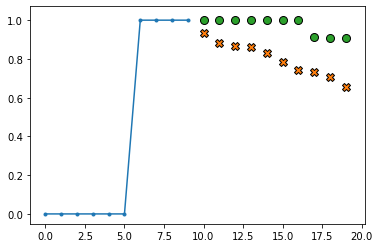

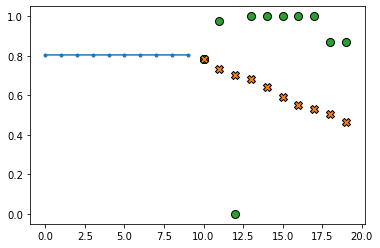

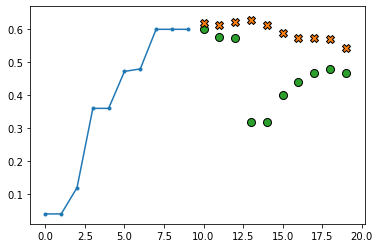

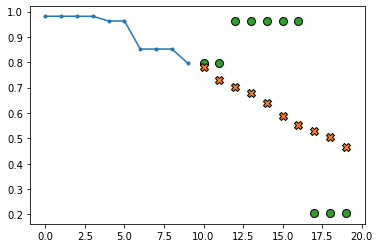

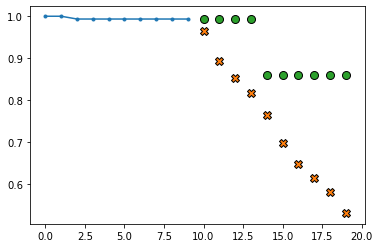

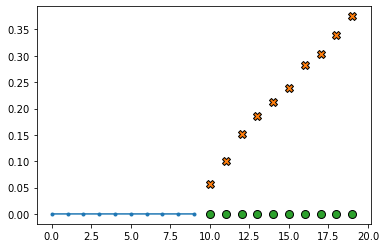

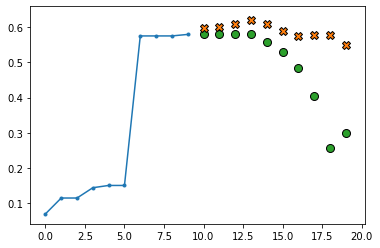

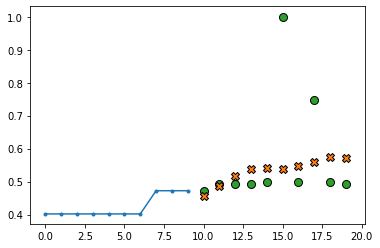

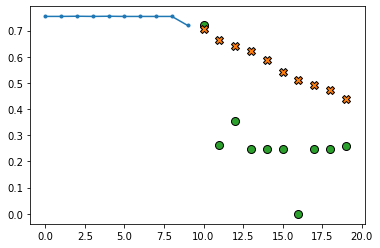

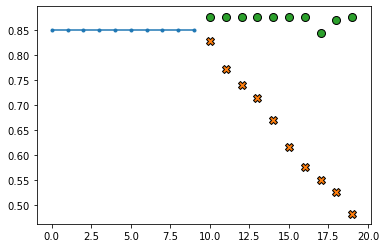

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/conv_model_10_10\assets


In [34]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Reshape([1, -1]),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(1,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=output_size)
])

_, conv_model_loss, conv_model_mae = compile_and_fit(conv_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, conv_model, 10)
conv_model.save(f'models/conv_model_{input_size}_{output_size}')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_1 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_14 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

17125/17125 [==============================] - 14s 821us/step - loss: 0.0762 - mean_absolute_error: 0.2128 - val_loss: 0.0792 - val_mean_absolute_error: 0.2226
Epoch 34/50
17125/17125 [==============================] - 19s 1ms/step - loss: 0.0762 - mean_absolute_error: 0.2127 - val_loss: 0.0791 - val_mean_absolute_error: 0.2225
Epoch 35/50
17125/17125 [==============================] - 17s 977us/step - loss: 0.0762 - mean_absolute_error: 0.2127 - val_loss: 0.0791 - val_mean_absolute_error: 0.2225
Epoch 36/50
17125/17125 [==============================] - 16s 939us/step - loss: 0.0761 - mean_absolute_error: 0.2126 - val_loss: 0.0791 - val_mean_absolute_error: 0.2225
Epoch 37/50
17125/17125 [==============================] - 15s 864us/step - loss: 0.0761 - mean_absolute_error: 0.2125 - val_loss: 0.0791 - val_mean_absolute_error: 0.2224
Epoch 38/50
17125/17125 [==============================] - 14s 834us/step - loss: 0.0761 - mean_absolute_error: 0.2125 - val_loss: 0.0791 - val_mean_absol

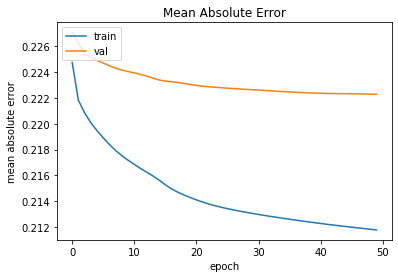

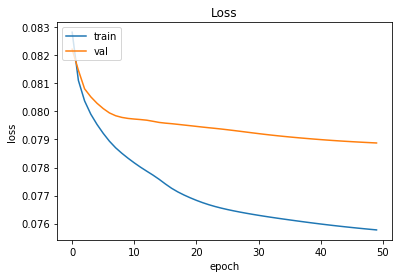

Test loss 0.07787613072543569
Test mae 0.22074249608464508
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


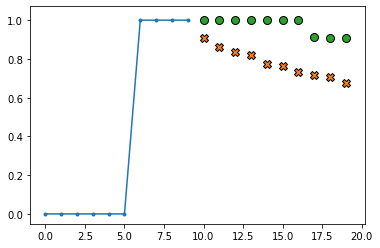

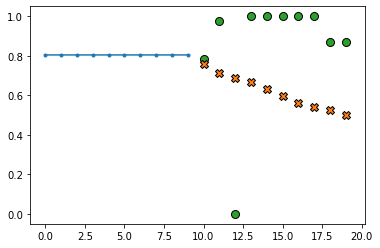

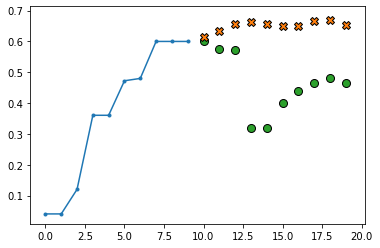

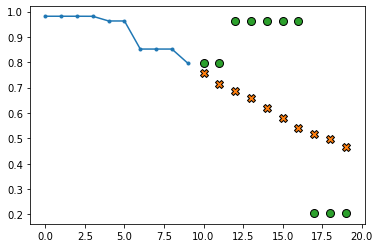

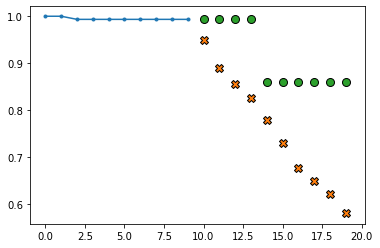

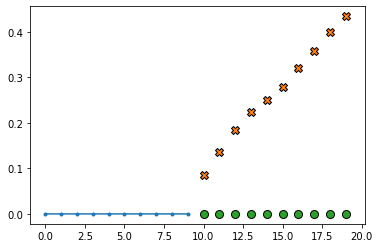

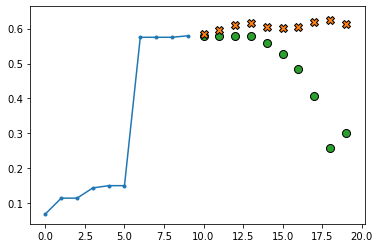

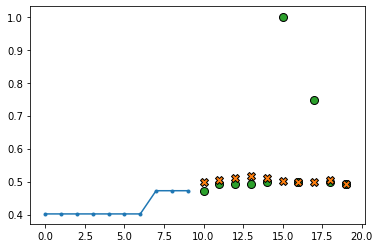

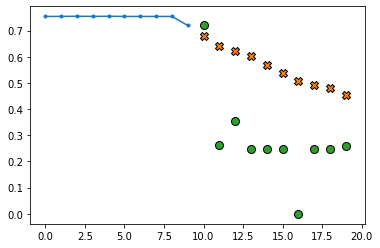

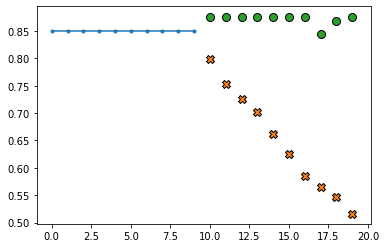

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: models/gru_model_10_10\assets


In [35]:
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1, -1]),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(units=output_size)
])

_, gru_model_loss, gru_model_mae = compile_and_fit(gru_model, train_dataset, valid_dataset, test_dataset)
plot_example(test_dataset, gru_model, 10)
gru_model.save(f'models/gru_model_{input_size}_{output_size}')

[0.22623166547821427, 0.22225402848142464, 0.2214490184250964, 0.22074249608464508]


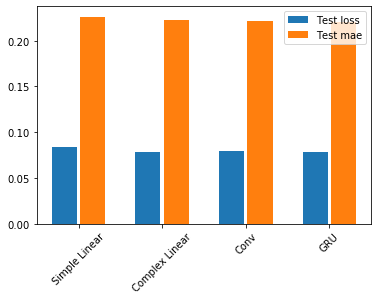

In [36]:
width = 0.3
test_loss = [simple_linear_model_loss, complex_linear_model_loss, conv_model_loss, gru_model_loss]
test_mae = [simple_linear_model_mae, complex_linear_model_mae, conv_model_mae, gru_model_mae]
print(test_mae)
x = np.arange(len(test_loss))
plt.bar(x - 0.17, test_loss, width, label='Test loss')
plt.bar(x + 0.17, test_mae, width, label='Test mae')
plt.xticks(ticks=x, labels=['Simple Linear', 'Complex Linear', 'Conv', 'GRU'], rotation=45)
plt.legend()

# Cross validation (only gru)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

17125/17125 [==============================] - 16s 954us/step - loss: 0.0769 - mean_absolute_error: 0.2142 - val_loss: 0.0766 - val_mean_absolute_error: 0.2167
Epoch 34/50
17125/17125 [==============================] - 15s 884us/step - loss: 0.0769 - mean_absolute_error: 0.2141 - val_loss: 0.0766 - val_mean_absolute_error: 0.2166
Epoch 35/50
17125/17125 [==============================] - 16s 949us/step - loss: 0.0769 - mean_absolute_error: 0.2141 - val_loss: 0.0766 - val_mean_absolute_error: 0.2166
Epoch 36/50
17125/17125 [==============================] - 15s 886us/step - loss: 0.0768 - mean_absolute_error: 0.2140 - val_loss: 0.0766 - val_mean_absolute_error: 0.2166
Epoch 37/50
17125/17125 [==============================] - 15s 888us/step - loss: 0.0768 - mean_absolute_error: 0.2139 - val_loss: 0.0766 - val_mean_absolute_error: 0.2165
Epoch 38/50
17125/17125 [==============================] - 17s 1ms/step - loss: 0.0768 - mean_absolute_error: 0.2139 - val_loss: 0.0766 - val_mean_absol

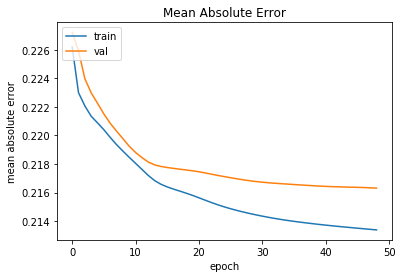

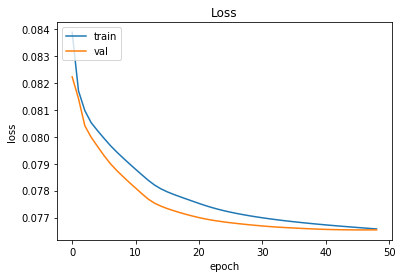

Test loss 0.07602572004156696
Test mae 0.21460087711382608
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conv

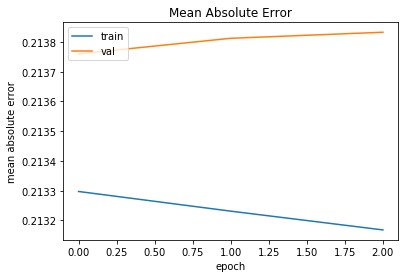

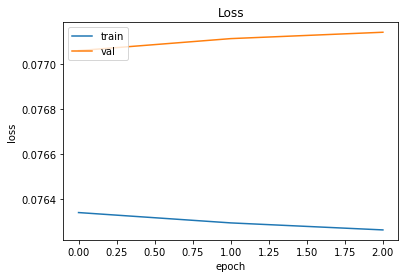

Test loss 0.0772084793349952
Test mae 0.21403539477372488
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conve

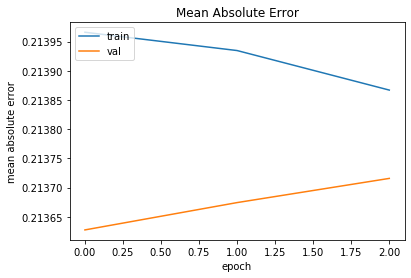

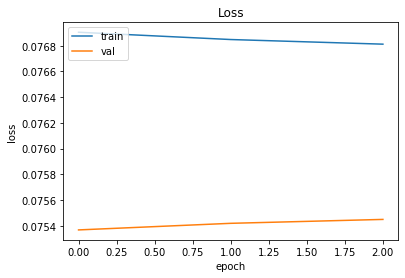

Test loss 0.07617180026798655
Test mae 0.2135797621284417
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conve

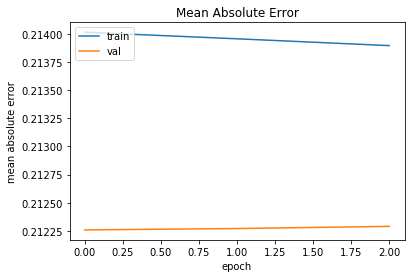

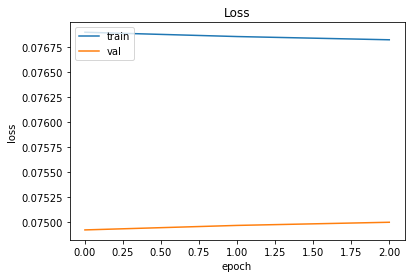

Test loss 0.0754286695779504
Test mae 0.21098157416429494
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conve

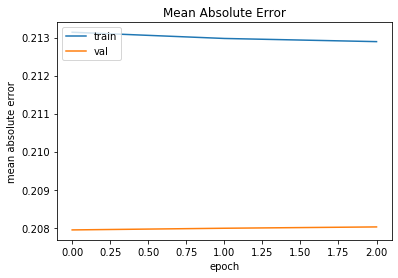

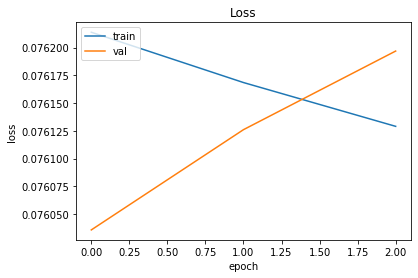

Test loss 0.07728859276870294
Test mae 0.2100030511315544
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conve

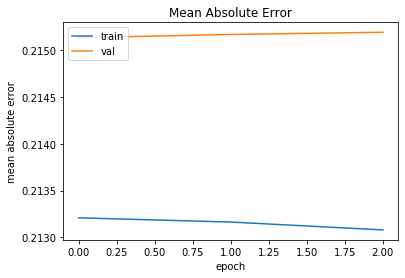

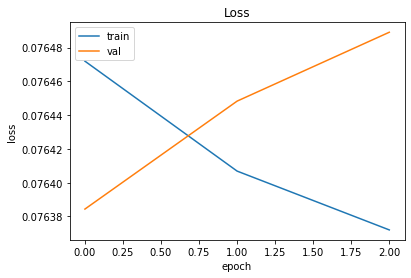

Test loss 0.07540023099543301
Test mae 0.21369309666008732
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conv

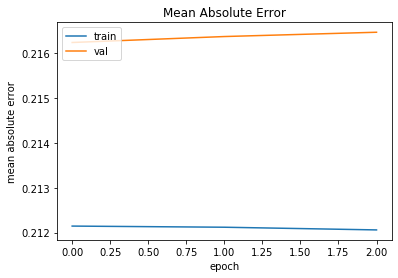

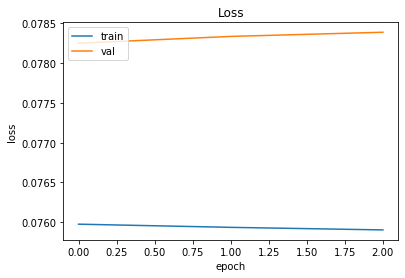

Test loss 0.0767658510556301
Test mae 0.21434316388793911
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conve

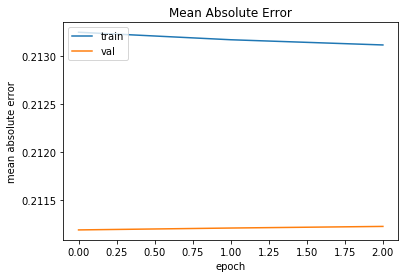

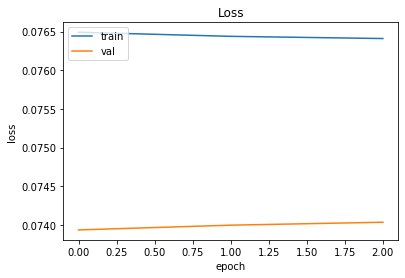

Test loss 0.07694925035386647
Test mae 0.21504711144355718
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conv

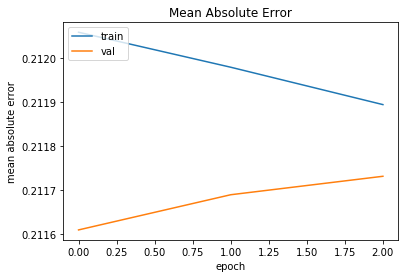

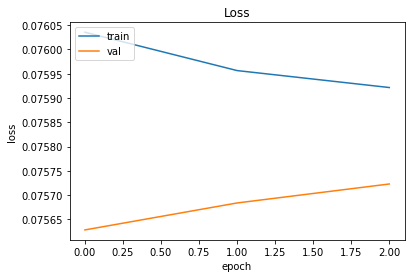

Test loss 0.07696722808673599
Test mae 0.2137235142652215
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (1, 1, 10)                0         
_________________________________________________________________
gru_2 (GRU)                  (1, 32)                   4224      
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   330       
Total params: 4,554
Trainable params: 4,554
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_conve

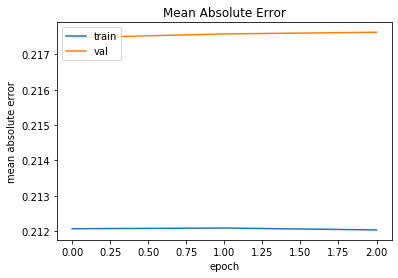

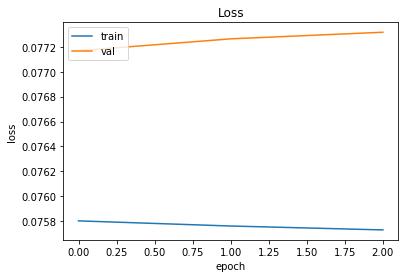

Test loss 0.07700428339017786
Test mae 0.2164522609038735


In [37]:
input_size = 10
output_size = 10
scalar = sklearn.preprocessing.MinMaxScaler()

input_series, output_series = ConvertItemsToTimeSeries(items_filtered, input_size, output_size, scalar)

gru_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1, -1]),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(units=output_size)
])

losses = []
maes = []
for i in range(10):
    train_input_set, valid_input_set, test_input_set, train_output_set, valid_output_set, test_output_set = SplitIntoTrainValTest(input_series, output_series, has_set_seed=False)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_input_set, train_output_set))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input_set, valid_output_set))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_input_set, test_output_set))

    _, gru_model_loss, gru_model_mae = compile_and_fit(gru_model, train_dataset, valid_dataset, test_dataset)
    losses.append(gru_model_loss)
    maes.append(gru_model_mae)

In [38]:
print(np.mean(losses))
print(np.mean(maes))

0.07652101058730454
0.21364598064725207


In [39]:
# loss/mae are close enough to the results we had in our first run, so it isn't just luck after all :)

# Future work

There is a lot to be done in terms of future work. This is only a foundation.

### More features

Data could include number of items sold, number of items bought, event date (may influence when item is bought/sold)

### The current data

The current data setup makes assumptions. It assumes all items are the same and follow the same pattern. Future work could be done to separate types into its own categories (emotes/costumes and costumes into their packages). The data also assumes the time between the data points are the same, which is not true (can vary from couple hours to days)

### Use of other knowledge to aid

There are other formulas in statistics / stock analysis to aid prediction. This doesn't even have to necessarily be machine learning.

### More methods/complex models

Cross validation would be helpful to ensure that the results are consistent for the rest of the models

Hyper parameter tuning would also aid much as well in getting the extra bit of accuracy

Dropout, regularizers, scaling data differently can be helpful

Other complex models include multiple layer lstm, seq2seq, reinforcement learning, etc... can produce better results